# [Decision Trees] Model using Different Featurization in NLP

# Loading data

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'same', 'ma', 'we', "hasn't", 'which', 'but', 'did', 'whom', "haven't", 'has', "don't", 'o', 'doing', 'down', 't', 'each', 'both', 'your', 'and', "couldn't", "needn't", "should've", 'can', 'it', 'are', 'about', 'an', 'ain', 'theirs', 'once', 'up', 'through', 'because', 'only', 'our', 'then', 'shan', "shan't", "won't", 'such', 'during', 'hasn', 're', "mightn't", 'over', 'against', 'before', "shouldn't", 'don', "she's", 'again', "doesn't", 'herself', "it's", 'me', 'what', 'all', 'they', 'themselves', "hadn't", 'yourself', 'into', 'nor', "weren't", 'haven', 'why', 'i', 'of', 'until', 'aren', 'himself', 'there', 'at', 'were', 'above', 'not', 'ourselves', 'them', 'more', 'been', 'have', "wasn't", 'needn', 'doesn', 'll', 'in', 'mustn', 'own', 'than', 'will', 'd', 'does', 'isn', 'shouldn', 'ours', 'his', 'their', 'he', "you're", 'too', 'here', 'other', 'you', 'with', 'hers', 'a', 'm', 'the', 'yourselves', 'further', 'y', 'be', 'while', 'some', 'mightn', 'that', 'do', "you'd", 'hadn', 'where'

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [09:00<00:00, 673.15it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.to_pickle("./preprocessed.pkl")

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./preprocessed.pkl")

# [2] Sorting data based on time

In [60]:
data['Time'] = pd.to_datetime(data['Time'])

# Random sampling
data = data.take(np.random.permutation(len(final))[:60000])
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
103883,36168,39316,B000MJU090,ARD88F3UHAS07,Michael Goodwin,5,6,1,1970-01-01 00:00:01.174867200,Anchovy - Love it or Hate it,I love anchovies. These are a great value. Som...,love anchovi great valu folk care anchovi salt...
128307,439258,475020,B000VTR1G6,A38BK73E4QRT6M,Jack Wengrosky,1,1,1,1970-01-01 00:00:01.265846400,Pods work great!,I bought the pod maker w/pods and they work gr...,bought pod maker pod work great dont need extr...


In [61]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(60000, 12)
1    50703
0     9297
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

# [4] Bag of Words (BoW)

In [22]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=20) 

X_train = count_vect.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (42000, 2000)
Test Data Size:  (18000, 2000)


## [4.1] Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

Depths = [3,4,5,6,7,8,9,10,11,15,17]
clf = DecisionTreeClassifier(class_weight="balanced")
param_grid = {'max_depth': Depths}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  1.9min finished


Best HyperParameter:  {'max_depth': 17}
Best Accuracy: 81.28%


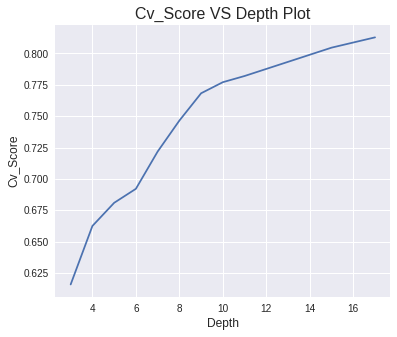

In [24]:
# plotting Cross-Validation Error vs Depth graph 
plt.figure(figsize=(6,5))
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('Cv_Score',size=12)
plt.title('Cv_Score VS Depth Plot',size=16)
plt.grid(True)
plt.show()

In [0]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 85.233%
Precision on test set: 0.866
Recall on test set: 0.973
F1-Score on test set: 0.916


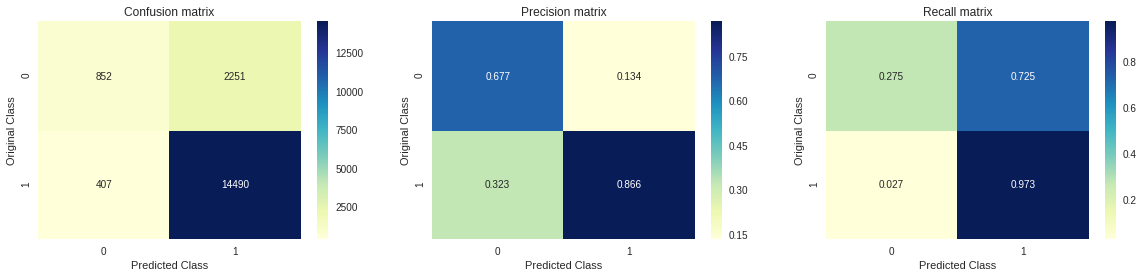

In [26]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=17)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

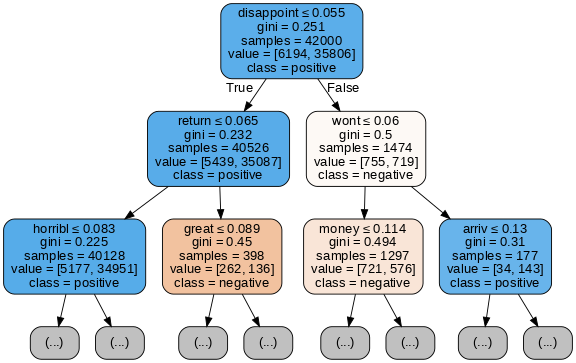

In [27]:
import graphviz 
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
#Create DOT data
data = tree.export_graphviz(clf,out_file=None, max_depth=2, class_names=target,filled=True,rounded=True,special_characters=True, feature_names=count_vect.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#Show graph
graph.set_size('"6,6!"')
Image(graph.create_png())

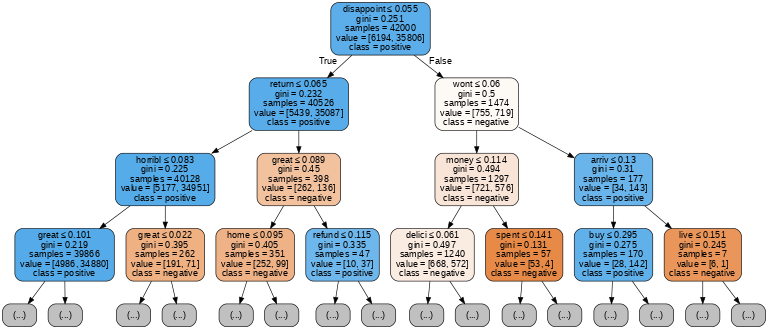

In [28]:
target = ['negative','positive']
#Create DOT data
data = tree.export_graphviz(clf,out_file=None, max_depth=3, class_names=target,filled=True,rounded=True,special_characters=True,feature_names=count_vect.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#Show graph
graph.set_size('"8,8!"')
Image(graph.create_png())

## [4.2] Feature Importance

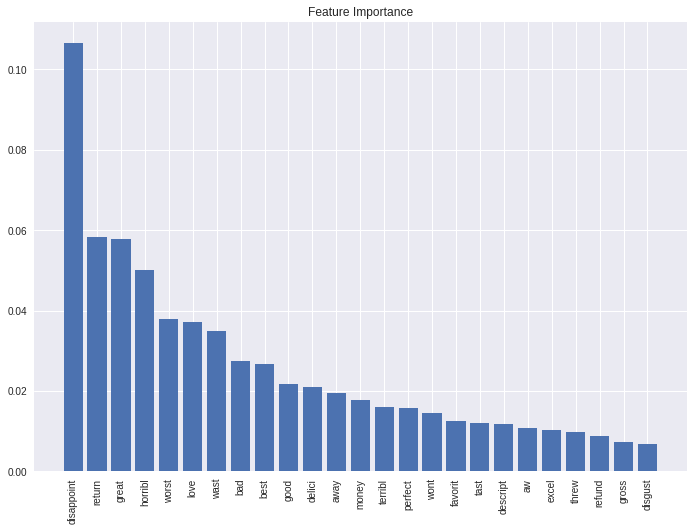

In [29]:
#feature importances from decision trees
importances = clf.feature_importances_

#Sort in descending order
indices = np.argsort(importances)[::-1][:25]

#Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})
#plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(25), importances[indices])
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)
plt.show()


# [5] TF-IDF

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [63]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=20) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (42000, 2000)
Test Data Size:  (18000, 2000)


## [5.1] Decision Tree

In [64]:
Depths = [3,4,5,6,7,8,9,10,11,15,17]
clf = DecisionTreeClassifier(class_weight="balanced")
param_grid = {'max_depth': Depths}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.0min finished


Best HyperParameter:  {'max_depth': 17}
Best Accuracy: 81.55%


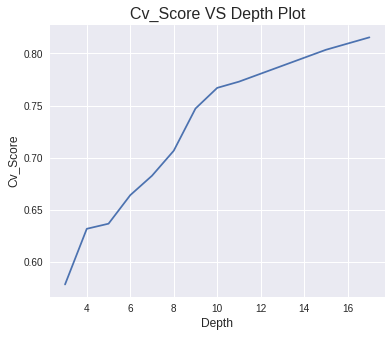

In [65]:
# plotting Cross-Validation Error vs Depth graph 
plt.figure(figsize=(6,5))
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('Cv_Score',size=12)
plt.title('Cv_Score VS Depth Plot',size=16)
plt.grid(True)
plt.show()

Accuracy on test set: 85.328%
Precision on test set: 0.862
Recall on test set: 0.979
F1-Score on test set: 0.917


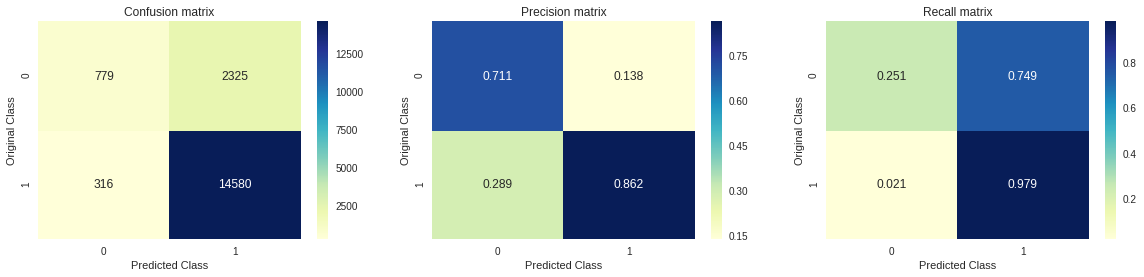

In [66]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=17)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

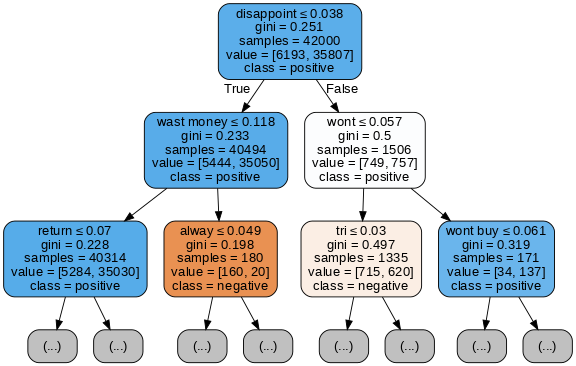

In [67]:
target = ['negative','positive']
#Create DOT data
data = tree.export_graphviz(clf,out_file=None, max_depth=2, class_names=target,filled=True,rounded=True,special_characters=True,feature_names=tfidf.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#Show graph
graph.set_size('"6,6!"')
Image(graph.create_png())

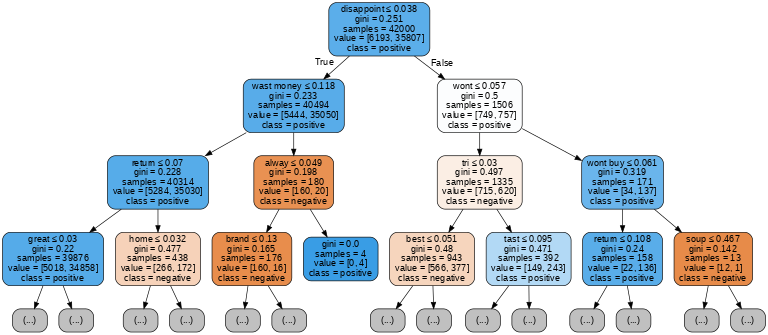

In [68]:
target = ['negative','positive']
#Create DOT data
data = tree.export_graphviz(clf,out_file=None, max_depth=3, class_names=target,filled=True,rounded=True,special_characters=True,feature_names=tfidf.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#Show graph
graph.set_size('"8,8!"')
Image(graph.create_png())

## [5.2] Feature Importance

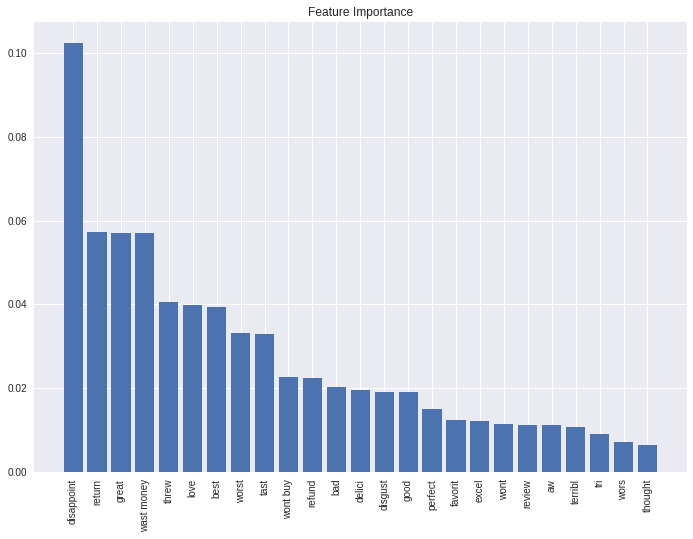

In [69]:
#feature importances from decision trees
importances = clf.feature_importances_

#Sort in descending order
indices = np.argsort(importances)[::-1][:25]

#Rearrange feature names so they match the sorted feature importances
names = tfidf.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})
#plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(25), importances[indices])
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)
plt.show()


# [6] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [46]:
print(data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10188
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'beetlejuic', 'excel', 'funni', 'movi', 'keaton', 'hilari', 'wacki', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch']


# [7] Avg Word2Vec

In [49]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [01:18<00:00, 766.10it/s]

60000
50


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [7.1] Decision tree

In [51]:
Depths = [3,4,5,6,7,8,9,10,11,15,17]
clf = DecisionTreeClassifier(class_weight="balanced")
param_grid = {'max_depth': Depths}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.0min finished


Best HyperParameter:  {'max_depth': 17}
Best Accuracy: 88.69%


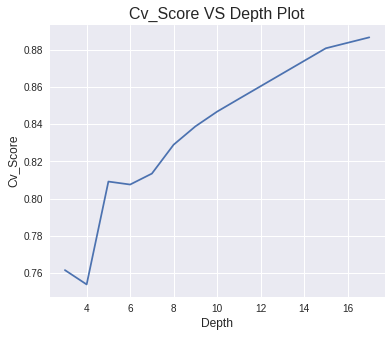

In [0]:
# plotting Cross-Validation Error vs Depth graph 
plt.figure(figsize=(6,5))
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('Cv_Score',size=12)
plt.title('Cv_Score VS Depth Plot',size=16)
plt.grid(True)
plt.show()

Accuracy on test set: 83.639%
Precision on test set: 0.873
Recall on test set: 0.938
F1-Score on test set: 0.904


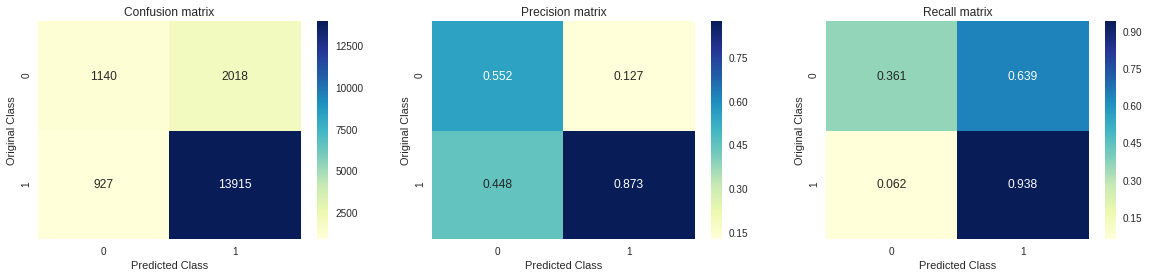

In [0]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [8] TF-IDF Word2Vec

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [01:37<00:00, 613.12it/s]


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [8.1] Decision Tree

In [0]:
Depths = [3,4,5,6,7,8,9,10,11,15,17]
clf = DecisionTreeClassifier(class_weight="balanced")
param_grid = {'max_depth': Depths}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.0min finished


Best HyperParameter:  {'max_depth': 17}
Best Accuracy: 87.89%


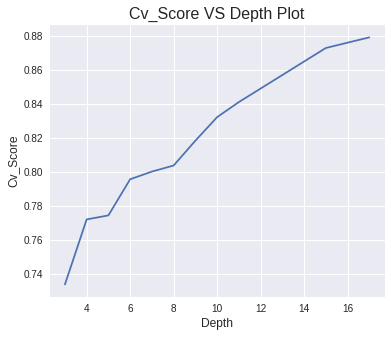

In [0]:
# plotting Cross-Validation Error vs Depth graph 
plt.figure(figsize=(6,5))
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('Cv_Score',size=12)
plt.title('Cv_Score VS Depth Plot',size=16)
plt.grid(True)
plt.show()

Accuracy on test set: 79.956%
Precision on test set: 0.868
Recall on test set: 0.893
F1-Score on test set: 0.880


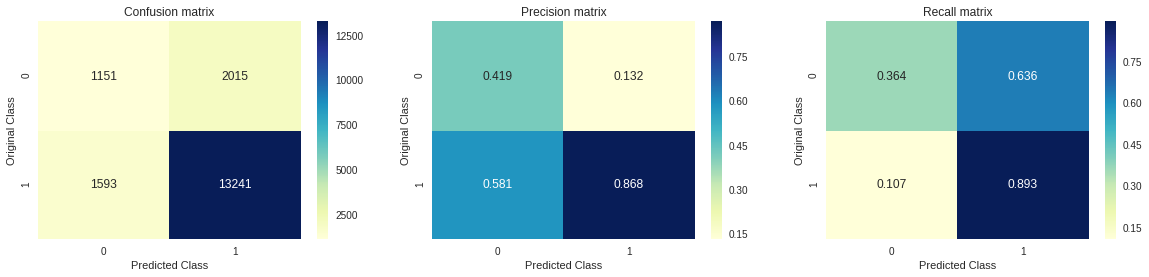

In [0]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=17)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# Performance Table

In [71]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "DEPTH", "F1-SCORE", "ACCURACY"]
 
x.add_row(["BOW", 17, 0.916, 85.233]) 
x.add_row(["TF_IDF", 17, 0.917, 85.328]) 
x.add_row(["AVG_W2VEC", 17, 0.904, 83.639]) 
x.add_row(["TFIDF_W2VEC", 17, 0.880, 79.956]) 

print('\t\tDECISION TREE')
print(x)

		DECISION TREE
+---------------+-------+----------+----------+
| FEATURIZATION | DEPTH | F1-SCORE | ACCURACY |
+---------------+-------+----------+----------+
|      BOW      |   17  |  0.916   |  85.233  |
|     TF_IDF    |   17  |  0.917   |  85.328  |
|   AVG_W2VEC   |   17  |  0.904   |  83.639  |
|  TFIDF_W2VEC  |   17  |   0.88   |  79.956  |
+---------------+-------+----------+----------+


# Conclusion

1.  TFIDF Featurization(max_depth=17) gave the best results with accuracy of 85.328% and F1-score of 0.917.
2.  Decision Trees on BOW and tfidf would have taken forever if had taken all the dimensions as it had huge dimension and hence tried with max 17 as max_depth
